#Análisis del Problema

El conjunto de datos contiene información sobre una empresa de telecomunicaciones la cuál se pretende clasificar si un cliente abandona o no el servicio ofrecido por la empresa.

## Descarga de los archivos de datos:
https://drive.google.com/file/d/1_zJDn7hODNO_3qUTmVvDNm78hqC74nLA/view?usp=sharing


### Autores
* Andrey Marín Chacón
* David González Agüero

#Entendimiento de los datos

El presente conjunto de datos contiene las siguientes características:

* **customerID**
* **gender**
* **SeniorCitizen**
* **Partner**
* **Dependents**
* **tenure**
* **PhoneService**
* **MultipleLines**
* **InternetService**
* **OnlineSecurity**
* **DeviceProtection**
* **TechSupport**
* **StreamingTV**
* **StreamingMovies**
* **Contract**
* **PaperlessBilling**
* **PaymentMethod**
* **MonthlyCharges**
* **TotalCharges**
* **Churn**

#Exploración de los datos

## Imports

In [ ]:
import pandas as pd
import numpy as np
import joblib

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder

from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split

## Funciones Auxiliares

In [ ]:
# Representación gráfica del límite de decisión
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

##1. Lectura del conjunto de datos

In [ ]:
df = pd.read_csv("sample_data/Telco-Customer-Churn.csv")

##2. Visualización preliminar de la información

In [ ]:
df.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [ ]:
# Observamos los valores únicos que tiene nuestra variable de salida Churn
df["Churn"].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

Ejecutando el siguiente comando para corroborar si existen o no valores nulos, nos muestra en el resultado una lista vacia, lo que significa que en este dataset no existen nulos.

In [ ]:
# Comprobación de si existen valores nulos
is_null = df.isna().any()
is_null[is_null]

Series([], dtype: bool)

Tampoco existen valores infinitos. Ya que de manera similar al caso anterior con los nulos, nos retorna una lista vacía.

In [ ]:
# Comprobación de la existencia de valores infinitos
is_inf = df.isin([np.inf, -np.inf]).any()
is_inf[is_inf]

Series([], dtype: bool)

In [ ]:
# El ID del cliente es irrelevante, entonces se va a eliminar de nuestro dataFrame
df = df.drop('customerID', axis=1)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
# Le indicamos que incluya todas las columnas, sin importar que no sean numéricas
df.describe(include = 'all')

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7043,7043.000000,7043,7043,7043.000000,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043.000000,7043,7043
unique,2,NaN,2,2,NaN,2,3,3,3,3,3,3,3,3,3,2,4,NaN,6531,2
top,Male,NaN,No,No,NaN,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,NaN,,No
freq,3555,NaN,3641,4933,NaN,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,NaN,11,5174
mean,NaN,0.162147,NaN,NaN,32.371149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN,NaN
std,NaN,0.368612,NaN,NaN,24.559481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN,NaN
min,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN,NaN
25%,NaN,0.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN,NaN
50%,NaN,0.000000,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN,NaN
75%,NaN,0.000000,NaN,NaN,55.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN,NaN


Parece ser que TotalCharges tiene valores numéricos, sin embargo aparece que es de tipo object. Vamos a internet convertir TotalCharges a numérico:

In [ ]:
# Transformamos los valores del atributo TotalCharges de categoricos a numericos
labelencoder = LabelEncoder()
df["TotalCharges"] = labelencoder.fit_transform(df["TotalCharges"])
df



,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,2505,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1466,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,157,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1400,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,925,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1597,No
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,5698,No
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,2994,No
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,2660,Yes


In [ ]:
# Le indicamos que incluya todas las columnas, sin importar que no sean numéricas
df.describe(include = 'all')

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7043,7043.000000,7043,7043,7043.000000,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043.000000,7043.000000,7043
unique,2,NaN,2,2,NaN,2,3,3,3,3,3,3,3,3,3,2,4,NaN,NaN,2
top,Male,NaN,No,No,NaN,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,NaN,NaN,No
freq,3555,NaN,3641,4933,NaN,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,NaN,NaN,5174
mean,NaN,0.162147,NaN,NaN,32.371149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,3257.794122,NaN
std,NaN,0.368612,NaN,NaN,24.559481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,1888.693496,NaN
min,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,0.000000,NaN
25%,NaN,0.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,1609.000000,NaN
50%,NaN,0.000000,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,3249.000000,NaN
75%,NaN,0.000000,NaN,NaN,55.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,4901.500000,NaN


Vemos que de color rojo tenemos ejemplos clasificados como Yes y de color verde ejemplos clasificados como No

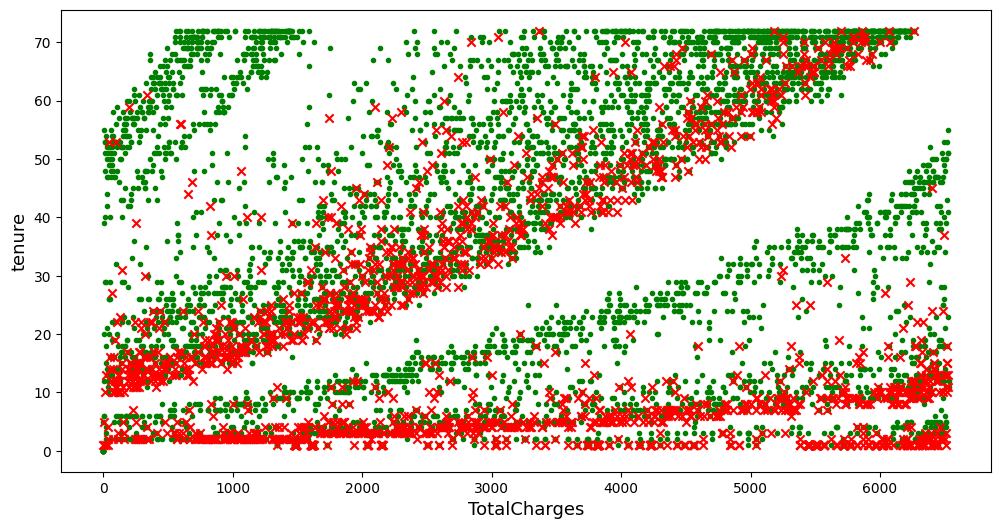

In [ ]:
# Representación gráfica de dos características
plt.figure(figsize=(12, 6))
plt.scatter(df["TotalCharges"][df['Churn'] == "No"], df["tenure"][df['Churn'] == "No"], c="g", marker=".")
plt.scatter(df["TotalCharges"][df['Churn'] == "Yes"], df["tenure"][df['Churn'] == "Yes"], c="r", marker="x")
plt.xlabel("TotalCharges", fontsize=13)
plt.ylabel("tenure", fontsize=13)
plt.show()

<Axes: >

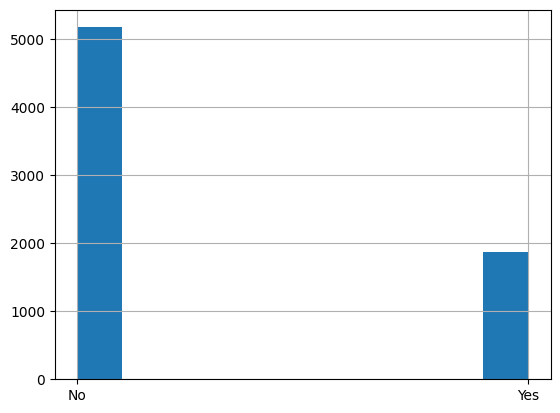

In [ ]:
# Mostrar los valores de la característica como un histograma

df["Churn"].hist()

In [ ]:
# Transformamos los valores del atributo Churn de categoricos a numericos
labelencoder = LabelEncoder()
df["Churn"] = labelencoder.fit_transform(df["Churn"])
df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,2505,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1466,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,157,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1400,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,925,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1597,0
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,5698,0
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,2994,0
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,2660,1


<Axes: >

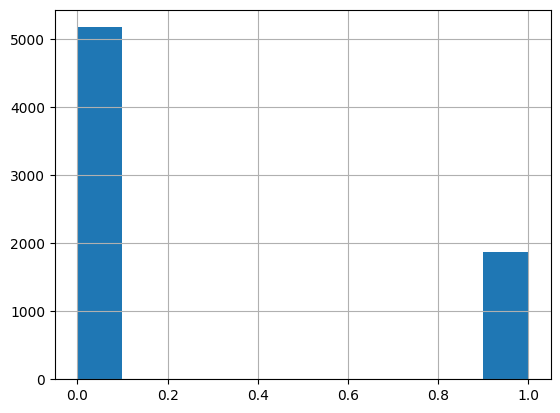

In [ ]:
# Mostrar los valores de la característica como un histograma

df["Churn"].hist()

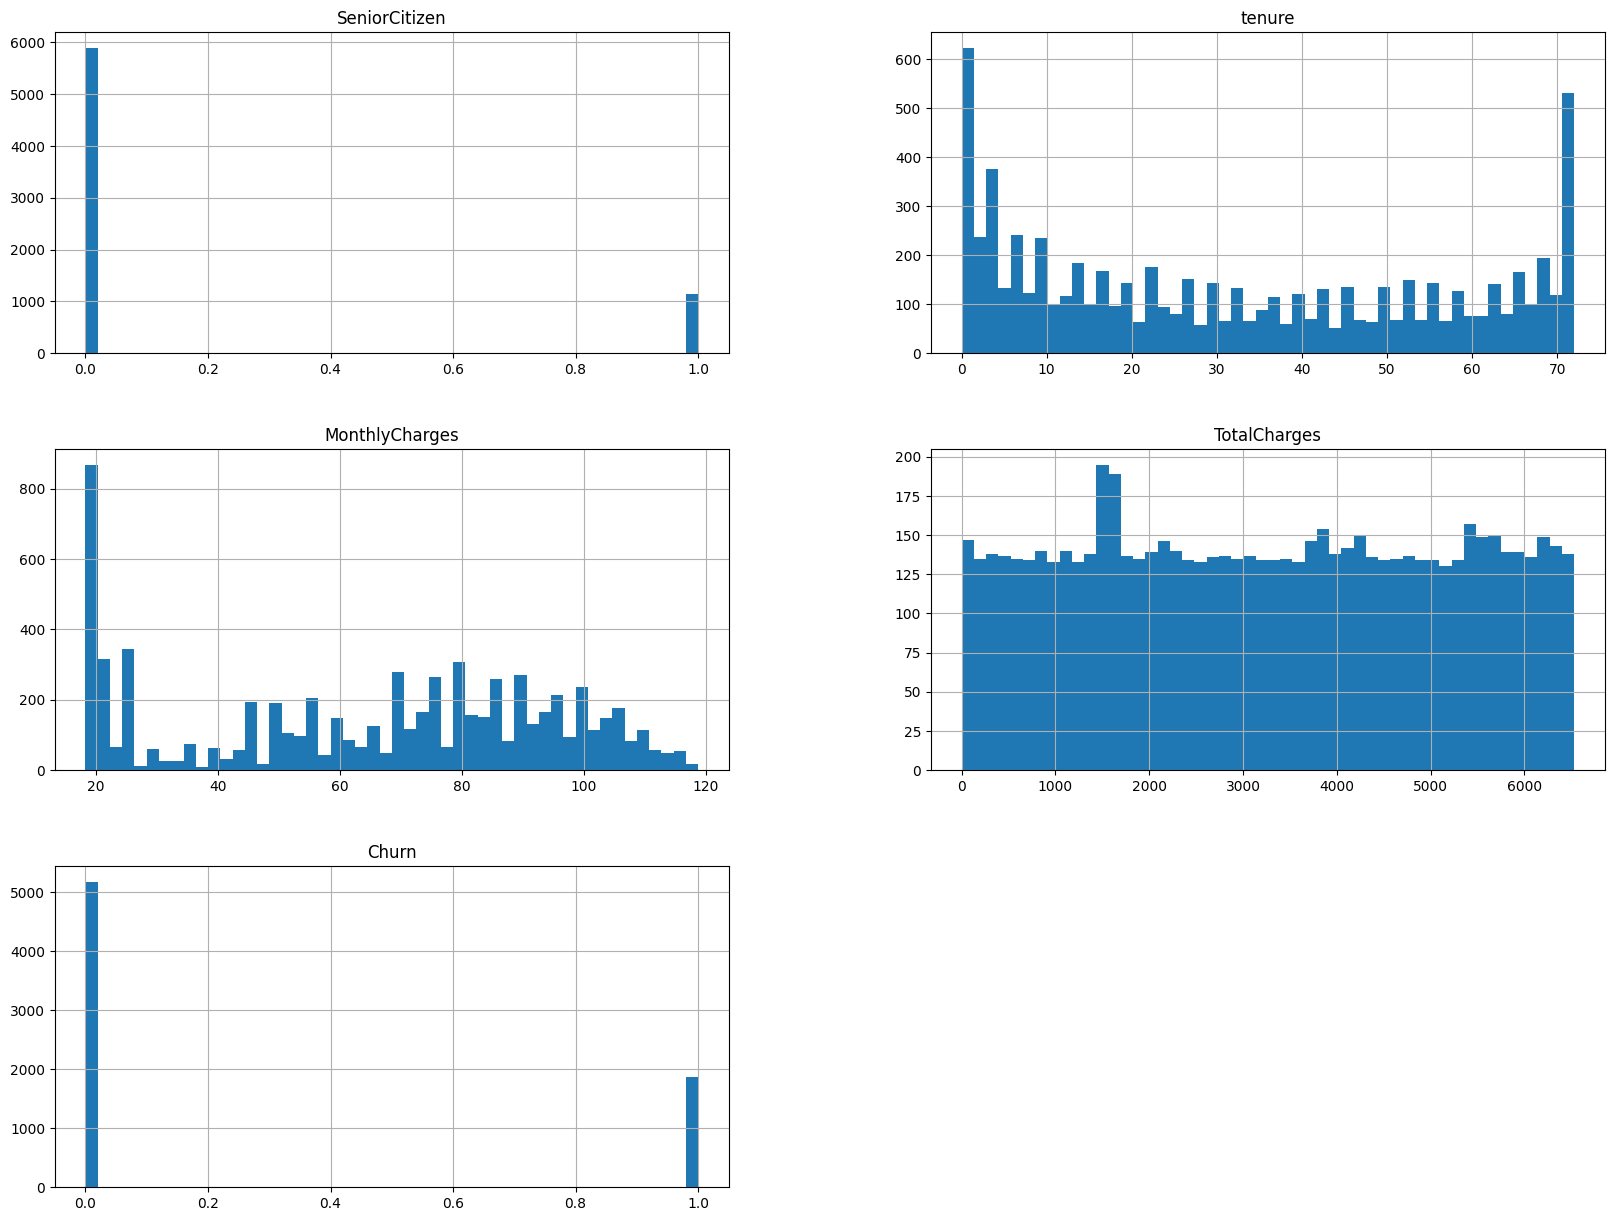

In [ ]:
# Representar gráficamente la distribución de los atributos
df.hist(bins=50, figsize=(20, 15))
plt.show()

##3. Division del conjunto de datos

In [ ]:
# División del conjunto de datos 80/20 ya que son poquitos datos
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5634 entries, 2142 to 860
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5634 non-null   object 
 1   SeniorCitizen     5634 non-null   int64  
 2   Partner           5634 non-null   object 
 3   Dependents        5634 non-null   object 
 4   tenure            5634 non-null   int64  
 5   PhoneService      5634 non-null   object 
 6   MultipleLines     5634 non-null   object 
 7   InternetService   5634 non-null   object 
 8   OnlineSecurity    5634 non-null   object 
 9   OnlineBackup      5634 non-null   object 
 10  DeviceProtection  5634 non-null   object 
 11  TechSupport       5634 non-null   object 
 12  StreamingTV       5634 non-null   object 
 13  StreamingMovies   5634 non-null   object 
 14  Contract          5634 non-null   object 
 15  PaperlessBilling  5634 non-null   object 
 16  PaymentMethod     5634 non-null   object

In [ ]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1409 entries, 185 to 1161
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            1409 non-null   object 
 1   SeniorCitizen     1409 non-null   int64  
 2   Partner           1409 non-null   object 
 3   Dependents        1409 non-null   object 
 4   tenure            1409 non-null   int64  
 5   PhoneService      1409 non-null   object 
 6   MultipleLines     1409 non-null   object 
 7   InternetService   1409 non-null   object 
 8   OnlineSecurity    1409 non-null   object 
 9   OnlineBackup      1409 non-null   object 
 10  DeviceProtection  1409 non-null   object 
 11  TechSupport       1409 non-null   object 
 12  StreamingTV       1409 non-null   object 
 13  StreamingMovies   1409 non-null   object 
 14  Contract          1409 non-null   object 
 15  PaperlessBilling  1409 non-null   object 
 16  PaymentMethod     1409 non-null   object

##4. Preparación del conjunto de datos

In [ ]:
#Hacemos una copia del df
train_copy = train_set.copy()
test_copy = test_set.copy()

In [ ]:
labelencoder = LabelEncoder()
# Aplicar label encoding a todas las características categóricas
for column in train_copy.columns:
    if train_copy[column].dtype == "object":
        train_copy[column] = labelencoder.fit_transform(train_copy[column])

# Aplicar label encoding a todas las características categóricas
for column in test_copy.columns:
    if test_copy[column].dtype == "object":
        test_copy[column] = labelencoder.fit_transform(test_copy[column])

In [ ]:
train_copy

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
2142,0,0,0,1,21,1,0,0,2,0,2,0,0,2,1,0,3,64.85,610,0
1623,0,0,0,0,54,1,2,1,0,2,0,0,2,2,2,1,0,97.20,4319,0
6074,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,2,23.45,1940,1
1362,1,0,0,0,4,1,0,1,0,0,0,0,0,0,0,1,2,70.20,2012,1
6754,1,0,0,1,0,1,2,0,2,2,0,2,0,0,2,1,0,61.90,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,1,0,1,0,1,1,0,1,2,0,0,0,2,2,0,1,2,95.00,6440,1
5191,0,0,1,1,23,1,2,0,2,2,2,2,2,2,2,1,1,91.10,1819,0
5226,1,0,1,1,12,1,0,2,1,1,1,1,1,1,0,1,2,21.15,2659,0
5390,1,1,0,0,12,1,2,1,0,0,2,0,2,2,0,1,2,99.45,370,1


In [ ]:
test_copy

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
185,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,2,24.80,2044,1
2715,1,0,0,0,41,1,2,2,1,1,1,1,1,1,0,1,0,25.25,6522,0
3825,0,0,1,1,52,1,0,2,1,1,1,1,1,1,2,0,3,19.35,67,0
1807,0,0,0,0,1,1,0,1,0,0,2,0,0,0,0,0,2,76.35,5822,1
132,1,0,0,0,67,1,0,0,0,0,0,2,0,0,2,0,0,50.55,2837,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6366,0,0,1,0,64,1,0,0,0,2,2,2,0,2,2,1,3,68.30,3716,0
315,1,0,1,1,51,1,2,1,2,2,0,2,2,2,1,0,1,110.05,4697,0
2439,1,0,1,1,17,1,0,2,1,1,1,1,1,1,1,0,0,19.90,2856,0
5002,0,0,1,1,69,0,1,0,2,0,2,0,0,2,2,1,1,43.95,2556,0


In [ ]:
#Mostramos correlación lineal entre todos los atributos del conjunto de datos
train_copy.corr()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
gender,1.000000,-0.005081,-0.007048,0.009767,0.000682,-0.010919,-0.000532,-0.004092,-0.019037,-0.023797,-0.008499,-0.009713,-0.009334,-0.007889,-0.002709,-0.015749,0.010505,-0.018287,-0.015223,-0.011729
SeniorCitizen,-0.005081,1.000000,0.014493,-0.211807,0.008823,0.004497,0.129565,-0.033053,-0.125902,-0.013401,-0.017165,-0.150404,0.027455,0.043194,-0.151073,0.154547,-0.036516,0.217649,0.040758,0.147078
Partner,-0.007048,0.014493,1.000000,0.450438,0.378964,0.029241,0.146258,0.007858,0.157997,0.162595,0.168417,0.128664,0.138388,0.127351,0.296531,-0.016722,-0.151003,0.105810,0.069181,-0.142266
Dependents,0.009767,-0.211807,0.450438,1.000000,0.162235,0.002471,-0.023704,0.046084,0.154474,0.092449,0.076965,0.138264,0.046993,0.028795,0.243383,-0.105860,-0.035525,-0.112823,-0.012584,-0.162356
tenure,0.000682,0.008823,0.378964,0.162235,1.000000,0.006502,0.350178,-0.033033,0.322432,0.366696,0.369116,0.322474,0.289802,0.299600,0.667426,0.008164,-0.357802,0.253803,0.154069,-0.344925
PhoneService,-0.010919,0.004497,0.029241,0.002471,0.006502,1.000000,-0.017764,0.389670,-0.012203,0.018529,-0.001812,-0.009599,0.052796,0.048165,0.001531,0.017933,0.003802,0.249830,0.082281,0.008886
MultipleLines,-0.000532,0.129565,0.146258,-0.023704,0.350178,-0.017764,1.000000,-0.107696,0.009286,0.129413,0.129596,0.012732,0.171384,0.184821,0.114051,0.170475,-0.177202,0.437514,0.117873,0.034952
InternetService,-0.004092,-0.033053,0.007858,0.046084,-0.033033,0.389670,-0.107696,1.000000,-0.025611,0.029433,0.046846,-0.023635,0.101037,0.092906,0.096207,-0.139638,0.098246,-0.321560,-0.061223,-0.047171
OnlineSecurity,-0.019037,-0.125902,0.157997,0.154474,0.322432,-0.012203,0.009286,-0.025611,1.000000,0.182314,0.183692,0.277661,0.057260,0.064440,0.368966,-0.146840,-0.084831,-0.049405,0.035712,-0.288143
OnlineBackup,-0.023797,-0.013401,0.162595,0.092449,0.366696,0.018529,0.129413,0.029433,0.182314,1.000000,0.189114,0.190663,0.138446,0.144508,0.280748,-0.016816,-0.114190,0.122372,0.085049,-0.192645


In [ ]:
# Mostrar la correlación entre los atributos del conjunto de datos
corr_matrix = train_copy.corr()
corr_matrix["Churn"].sort_values(ascending=False)

Churn               1.000000
PaperlessBilling    0.191324
MonthlyCharges      0.188574
SeniorCitizen       0.147078
PaymentMethod       0.100844
MultipleLines       0.034952
TotalCharges        0.019082
PhoneService        0.008886
gender             -0.011729
StreamingMovies    -0.032716
StreamingTV        -0.037937
InternetService    -0.047171
Partner            -0.142266
Dependents         -0.162356
DeviceProtection   -0.172989
OnlineBackup       -0.192645
TechSupport        -0.278303
OnlineSecurity     -0.288143
tenure             -0.344925
Contract           -0.394085
Name: Churn, dtype: float64

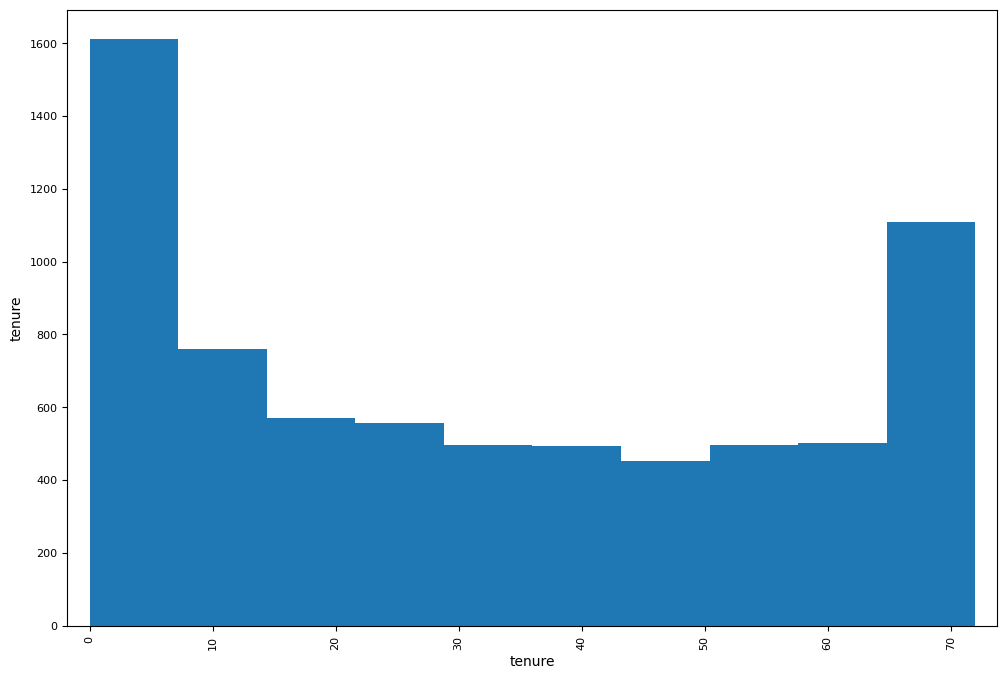

In [ ]:
# Correlaciones representadas gráficamente
atributos = ["Contract", "tenure", "OnlineSecurity"]

scatter_matrix(df[atributos], figsize=(12, 8))
plt.show()

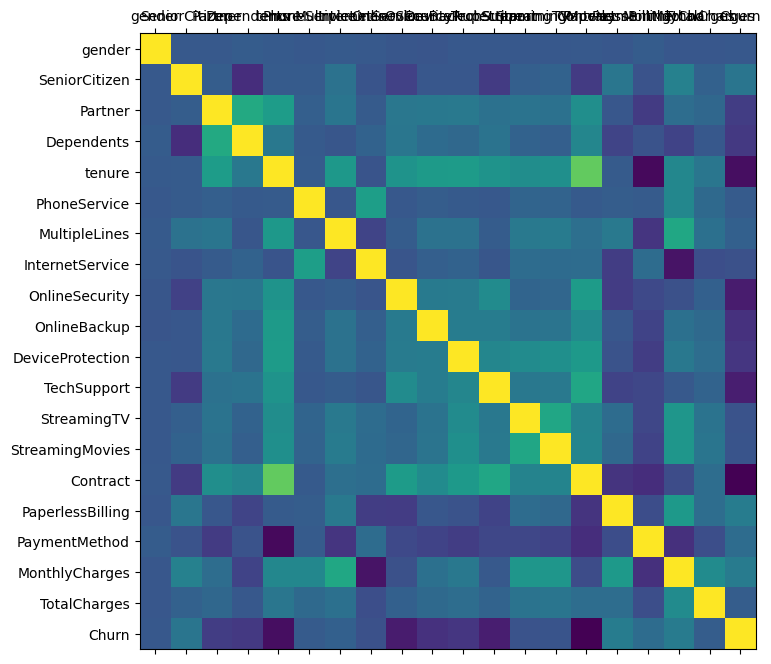

In [ ]:
# Representar gráficamente la matriz de correlación
corr = train_copy.corr()
fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns);
plt.yticks(range(len(corr.columns)), corr.columns);

In [ ]:
# Separamos las características de entrada de la característica de salida
X_train = train_set.drop("Churn", axis=1)
X_train_copy = train_copy.drop("Churn", axis=1)
y_train = train_set["Churn"].copy()

X_test = test_set.drop("Churn", axis=1)
X_test_copy = test_copy.drop("Churn", axis=1)
y_test = test_set["Churn"].copy()

#Modelo SVC: Gaussian Kernel

In [ ]:
X_train_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5634 entries, 2142 to 860
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5634 non-null   int64  
 1   SeniorCitizen     5634 non-null   int64  
 2   Partner           5634 non-null   int64  
 3   Dependents        5634 non-null   int64  
 4   tenure            5634 non-null   int64  
 5   PhoneService      5634 non-null   int64  
 6   MultipleLines     5634 non-null   int64  
 7   InternetService   5634 non-null   int64  
 8   OnlineSecurity    5634 non-null   int64  
 9   OnlineBackup      5634 non-null   int64  
 10  DeviceProtection  5634 non-null   int64  
 11  TechSupport       5634 non-null   int64  
 12  StreamingTV       5634 non-null   int64  
 13  StreamingMovies   5634 non-null   int64  
 14  Contract          5634 non-null   int64  
 15  PaperlessBilling  5634 non-null   int64  
 16  PaymentMethod     5634 non-null   int64 

In [ ]:
from sklearn.svm import SVC

# SVM Large Margin Classification
svm_gaussian = SVC(kernel="rbf", gamma=0.5, C=1000)
svm_gaussian.fit(X_train_copy, y_train)

SVC(C=1000, gamma=0.5)

In [ ]:
#Hacemos las predicciones
y_pred = svm_gaussian.predict(X_test_copy)
y_pred

array([1, 0, 0, ..., 0, 0, 0])

#Evaluación

In [ ]:
print("F1 score:", f1_score(y_test, y_pred, pos_label=0.0))

F1 score: 0.849792531120332


#Arbol Decisión

In [ ]:
from sklearn.tree import DecisionTreeClassifier

MAX_DEPTH = 20


clf_tree = DecisionTreeClassifier(max_depth=MAX_DEPTH, random_state=42)
clf_tree.fit(X_train_copy, y_train)

DecisionTreeClassifier(max_depth=20, random_state=42)

In [ ]:
# Predecimos con el conjunto de datos de validación
y_pred = clf_tree.predict(X_test_copy)

In [ ]:
print("F1 score:", f1_score(y_test, y_pred, pos_label=0.0))

F1 score: 0.8063583815028901


In [ ]:
# Salvar el modelo en archivo .pkl
joblib.dump(clf_tree, "04AbandonoCLientes.pkl")

['04AbandonoCLientes.pkl']

In [ ]:
# Cargar modelo
#svmCargado = joblib.load("04AbandonoCLientes.pkl")

#Conclusión
Utilizando el algoritmo de máquinas de soporte vectorial haciendo uso del kernel gaussiano, se obtuvo un F1 Score de 84%, mientras que aplicandolo en Arboles de decisión se obtuvo un F1 Score del 80%. Lo que quiere decir que el algoritmo de máquinas de soporte vectorial parece predecir mejor para este conjunto de datos.